In [1]:
# https://github.com/karpathy/micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from typing import List

%matplotlib inline

In [3]:
 def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

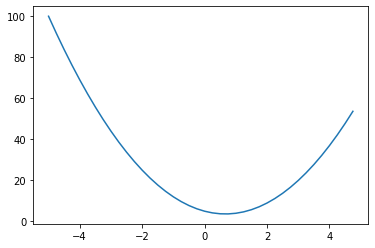

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
h = 0.001
x = 0.5

(f(x + h) - f(x))

-0.0009969999999999146

In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print(f"d2: {d2}, d1: {d1}, slope: {(d2 - d1)/h}")

d2: 4.0002, d1: 4.0, slope: 2.0000000000042206


In [11]:
class Value:
    def __init__(self, data, prev=None, op=None, label=''):
        self._data = data
        self._prev = prev
        self._op = op
        self._grad = 0.0
        # backward is a function that propagates gradient values to previous nodes.
        # Its implementation depends on how the Value node is created.
        # By default - this does nothing.
        # i.e we assume its a leaf node (or leftmost node in our computational graph).
        self._backward = lambda: None 
        self._label = label
            
    @property
    def grad(self):
        return self._grad
    
    @grad.setter
    def grad(self, val):
        self._grad = val
    
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, val):
        self._data = val
    
    @property
    def prev(self):
        return self._prev
    
    @property
    def op(self):
        return self._op
    
    @property
    def label(self):
        return self._label
    
    @label.setter
    def label(self, l):
        self._label = l
        
    def __repr__(self):
        return f"Value(data={self.data},label={self.label})"
    
    def __add__(self, o):
        other = Value(o, label=str(o)) if isinstance(o, (int, float)) else o


        out = Value(self.data + other.data, (self, other), '+', label=f"{self.label}+{other.label}")
        
        def _backward():
            # Local derivate * output node gradient (chain rule).
            # Computes d(self)/dL as d(self)/dout * dout/dL where L is the final output node.
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        
        out._backward = _backward
    
        return out
    
    def __radd__(self, o):
        return self + o
    
    def __mul__(self, o):
        other = Value(o, label=str(o)) if isinstance(o, (int, float)) else o
        
        out = Value(self.data * other.data, (self, other), '*', label=f"{self.label}*{other.label}")
        
        def _backward():
            # Local derivate * output node gradient (chain rule).
            # Computes d(self)/dL as d(self)/dout * dout/dL where L is the final output node.
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
            
    def __pow__(self, n):
        assert isinstance(n, (int, float)), "only supporting int, float powers"
        
        out = Value(self.data**n, (self, ), f"**{n}", label=f"{self.label}**{n}")
        
        def _backward():
            self.grad += n * self.data**(n - 1) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __sub__(self, o):
        return self + (-o)
    
    def __neg__(self):
        return self * -1
    
    def __rsub__(self, o):        
        return -self + o
        
    def __truediv__(self, other):
        return self * (other**-1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1.0) / (math.exp(2*x) + 1.0)
        
        out = Value(t, (self,), 'tanh', label=f"tanh({self.label})")
        
        def _backward():
            # Local derivate * output node gradient (chain rule).
            # Computes d(self)/dL as d(self)/dout * dout/dL where L is the final output node.
            self.grad += (1 - out.data**2) * out.grad
        
        out._backward = _backward
    
        return out 
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp', label=f"exp({self.label})")
    
        def _backward():
            self.grad = out.data * out.grad
    
        out._backward = _backward
        
        return out
    
    def backward(self):
        # Do a topological sort of nodes
        # This will help us do backprop only after children are done.
        visited = set()
        nodes = []
    
        def build0(node):
            if node not in visited:
                visited.add(node)
                if node.prev is not None:
                    for n in node.prev:
                        build0(n)
                nodes.append(node)

        build0(self)
        
        self.grad = 1.0
        for node in reversed(nodes):
            node._backward()

In [12]:
a = Value(3.0, label="a")
print(a * 2)
print(a + 2)
print(2 * a)
print(a**2)
print(a - 4)
print(-a)

Value(data=6.0,label=a*2)
Value(data=5.0,label=a+2)
Value(data=6.0,label=a*2)
Value(data=9.0,label=a**2)
Value(data=-1.0,label=a+-4)
Value(data=-3.0,label=a*-1)


In [13]:
# Plot
def _build(root):    
    """Returns list of nodes and edges in the graph"""
    
    nodes = set()
    edges = set()
    
    unexplored = [root]
    while (len(unexplored) > 0):
        n = unexplored.pop()
        nodes.add(n)
        if n.prev is not None:
            for p in n.prev:
                if p not in nodes:
                    unexplored.append(p)
                    edges.add((p, n))

    return nodes, edges

def node_label(val):
    return f"""<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
  <TR>
    <TD>{val.label}</TD>
    <TD>data: {val.data:.4f}</TD>
    <TD>grad: {val.grad:.4f}</TD>
  </TR>
</TABLE>>"""

def graph(final_node):
    dot = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'}, comment='Computational Graph')

    nodes, edges = _build(final_node)

    # Add all nodes to the graph
    # Handle nodes that have op present
    for node in nodes:
        uid = str(id(node))
        dot.node(name=uid, label=node_label(node), shape="plaintext")
        if node.op is not None:
            op_id = uid + node.op
            dot.node(name=op_id, label=node.op)
            dot.edge(op_id, uid)

    # Add all edges
    # We assume there is always an op connecting two nodes.
    for edge in edges:
        start, end = edge
        s_id = str(id(start))
        e_id = str(id(end))
        dot.edge(s_id, e_id + end.op)
        
    return dot


graph(L)

NameError: name 'L' is not defined

In [14]:
def grad():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    
    L = a * b + c    
    L1 = L.data
    L2 = L1 + h
    
    return (L2 - L1)/h

grad()

1.000000000000334

Value(data=0.8813735870195432,label=z)


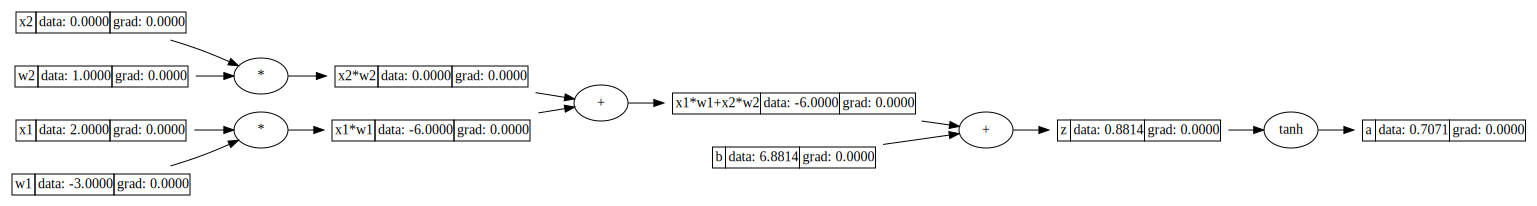

In [15]:
# Initialize Neuron with 2 inputs
# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")


# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias
b = Value(6.8813735870195432, label="b")

# Output
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2
z =  x1w1x2w2 + b
z.label = 'z'
print(z)
a = z.tanh()
a.label = 'a'
#a = np.tanh(z.data)

graph(a)

In [17]:
# Backprop through tanh

# a = tanh(x)
# da/dn = 1 - tanh(x)**2
# = 1 - a**2

In [18]:
# Use dz to represent dL/dz
# Manual backprop

dz = 1 - a.data**2
z.grad = dz

# Cause its a plus operation with 1 as coefficient - dz just flows through
x1w1.grad = dz
x2w2.grad = dz

# grad wrt x1. Simple chainrule
# dx1 = w1 * dx1w1
# dw1 = x1 * dx1w1 
dx1 = w1.data * x1w1.grad
dw1 = x1.data * x1w1.grad

dx2 = w2.data * x2w2.grad
dw2 = x2.data * x2w2.grad

x1.grad = dx1
w1.grad = dw1
x2.grad = dx2
w2.grad = dw2

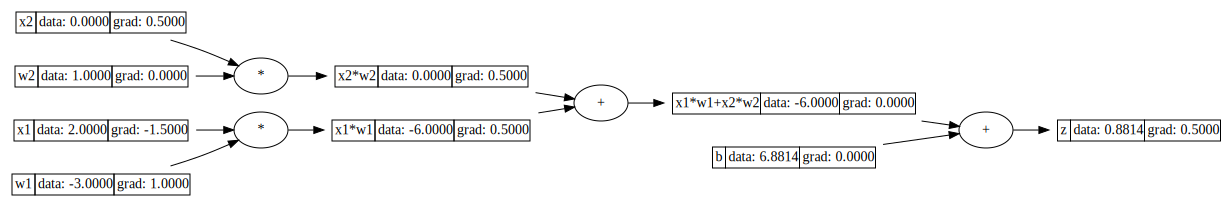

In [19]:
graph(z)

In [20]:
from IPython import display

backprop on a


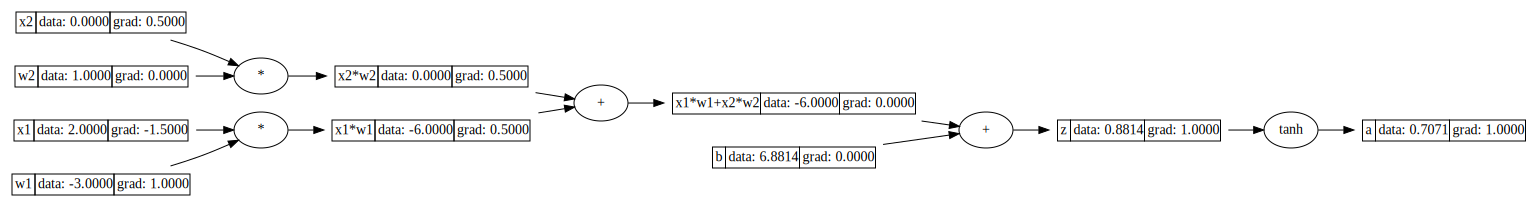

backprop on z


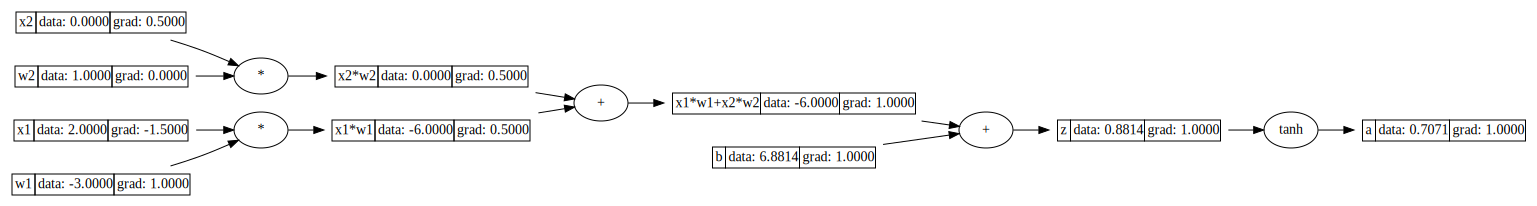

backprop on b


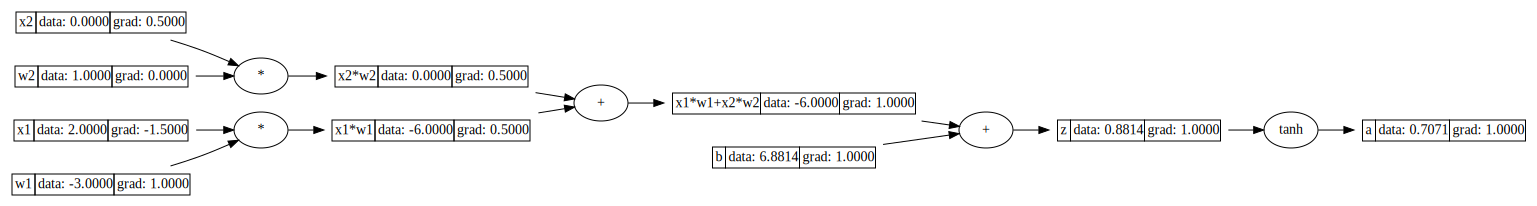

backprop on x1w1x2w2


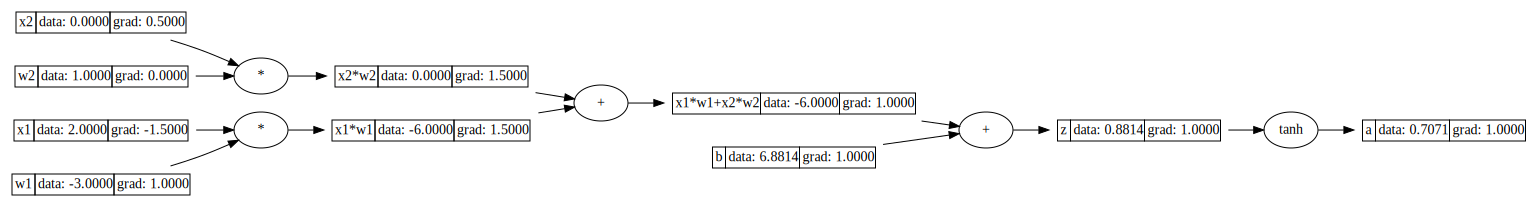

backprop on x1w1 x2w2


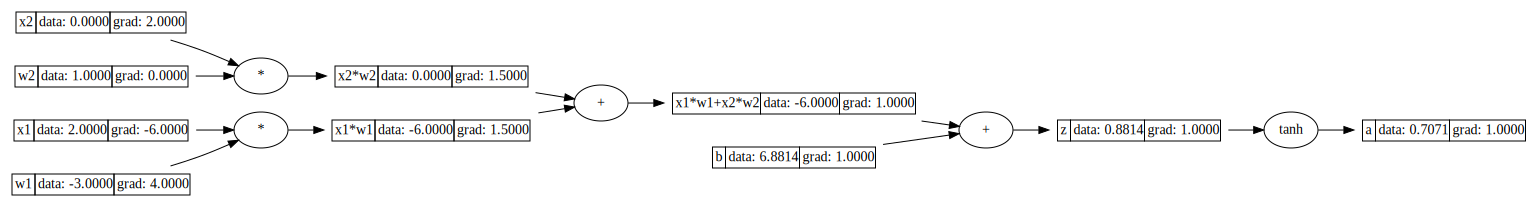

backprop on x1 x2 w1 w2. Should do nothing


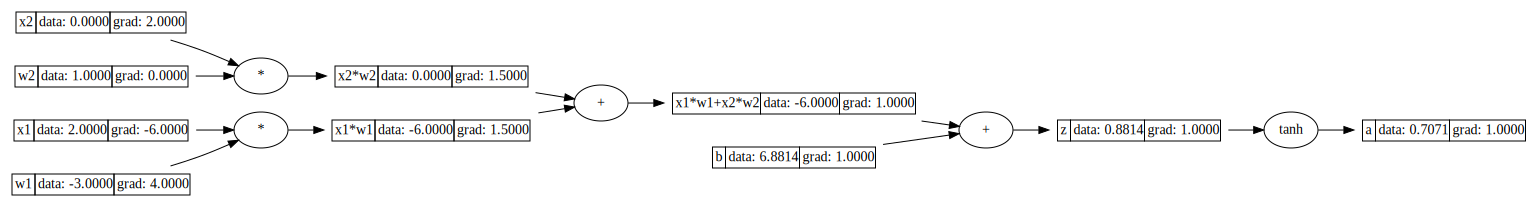

In [21]:
# Implement reverse-mode autodiff using the backward function
# Reinitialize the values so that grad is 0.

a.grad = 1.0
# This will propagate the gradient by one step
a._backward()
print("backprop on a")

display.display_svg(graph(a))

# Backprop by one more step
z._backward()
print("backprop on z")
display.display_svg(graph(a))

# Do so for b and x1w1x2w2
# Does nothing
print("backprop on b")
b._backward()
display.display_svg(graph(a))

# Sets grad values for x2w2 and x1w1
print("backprop on x1w1x2w2")
x1w1x2w2._backward()

display.display_svg(graph(a))

print("backprop on x1w1 x2w2")
x1w1._backward()
x2w2._backward()

display.display_svg(graph(a))

print("backprop on x1 x2 w1 w2. Should do nothing")

x1._backward()
x2._backward()
w1._backward()
w2._backward()

display.display_svg(graph(a))

Graph before backprop


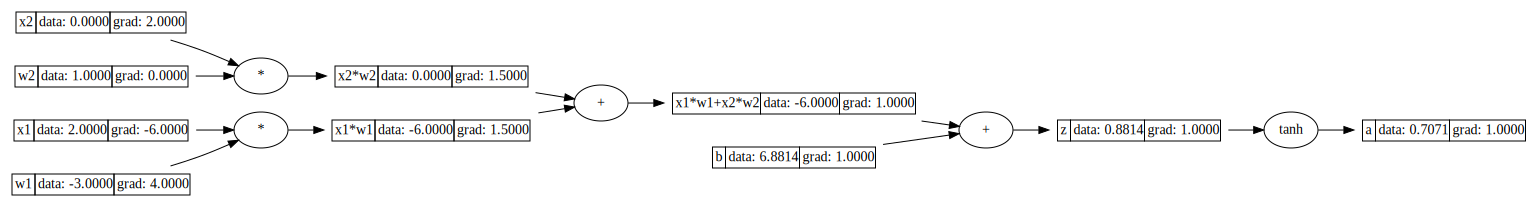

Graph after backprop


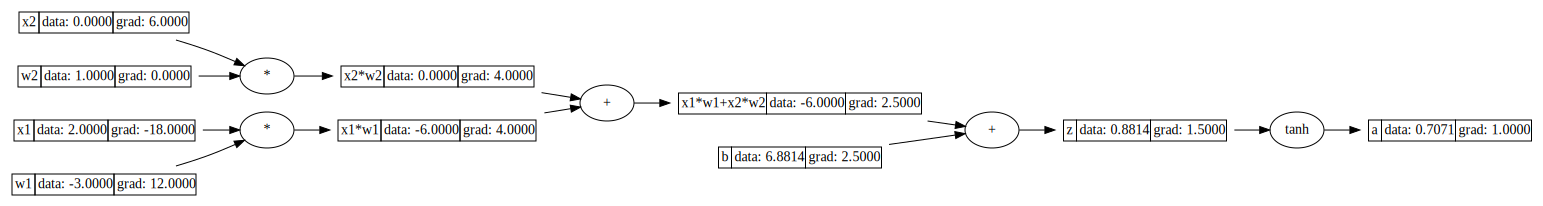

In [22]:
print("Graph before backprop")
display.display_svg(graph(a))

a.backward()

print("Graph after backprop")
display.display_svg(graph(a))

Before backprop


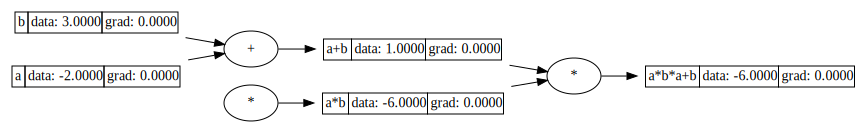

After backprop


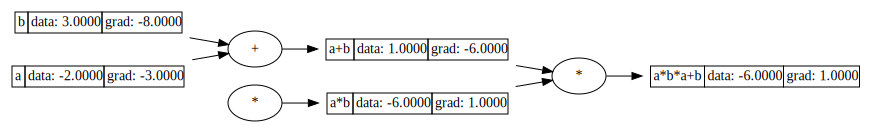

In [23]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
e = a + b
f = d * e

print("Before backprop")
display.display_svg(graph(f))

f.grad = 1.0
f.backward()

print("After backprop")
display.display_svg(graph(f))

Value(data=0.8813735870195432,label=z)
a using tanh function


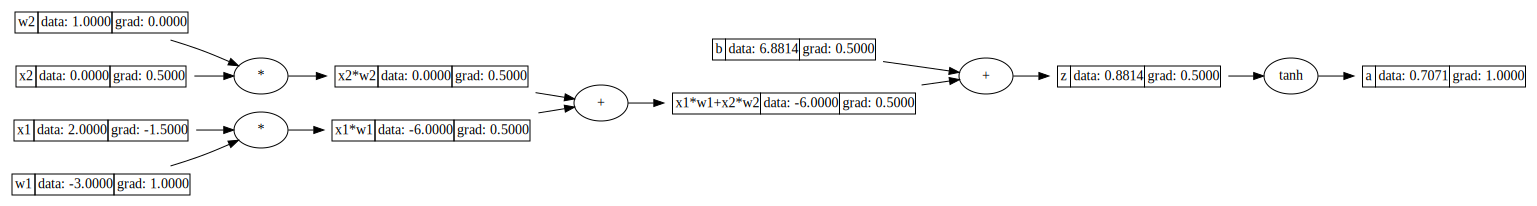

In [24]:
# tanh two ways

# Initialize Neuron with 2 inputs
# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")


# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias
b = Value(6.8813735870195432, label="b")

# Output
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2
z =  x1w1x2w2 + b
z.label = 'z'
print(z)
a = z.tanh()
a.label = 'a'
a.backward()

print("a using tanh function")
display.display_svg(graph(a))

Value(data=0.8813735870195432,label=n)


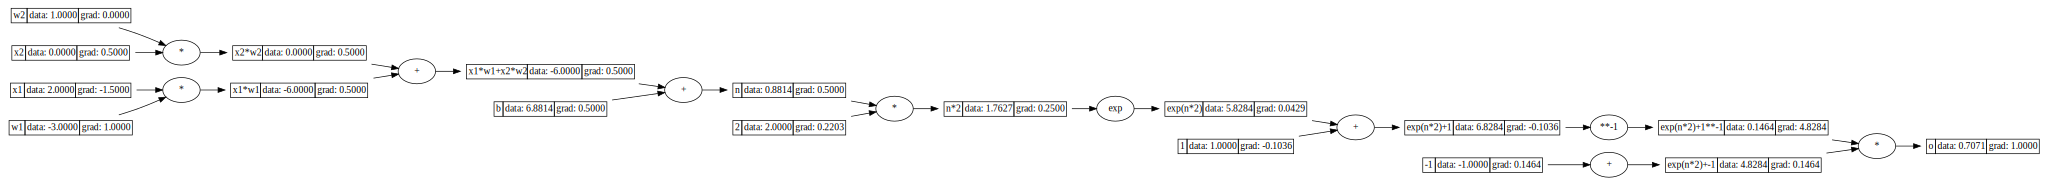

In [25]:
# Initialize Neuron with 2 inputs
# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")


# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias
b = Value(6.8813735870195432, label="b")

# Output
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2

n =  x1w1x2w2 + b
n.label = 'n'
print(n)

e = (2*n).exp()
# e.grad = 0.0429
# e._backward()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()


# print("a using primitive ops")

display.display_svg(graph(o))

In [26]:
  # autodiff using pytorch

import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.881373587]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


/home/sid/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
# graph(n)

In [28]:
import random
from typing import List
from littlegrad.engine import Value

class Neuron:
    def __init__(self, n_in, use_seed=False):
        # For debugging
        if use_seed:
            random.seed(999)
        self.w = [Value(random.uniform(-1, 1), label=f"w{i}") for i in range(n_in)]
        self.b = Value(random.uniform(-1, 1), label="b")

    def __call__(self, x):
        # w * x + b
        z = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        a = z.tanh()
        a.label = "a"

        return a

    @property
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]

        return outputs[0] if len(outputs) == 1 else outputs

    @property
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters]

class MLP:
    def __init__(self, n_in, n_outs: List):
        # Create layers with n_out neurons in each
        # We'll start with a layer for the inputs
        # Then just pass output of each layer to subsequent ones
        n_sizes = [n_in] + n_outs
        self.layers = [Layer(n_sizes[i], n_sizes[i+1] ) for i in range(len(n_outs))]


    def __call__(self, x):
        prev_out = x
        for l in self.layers:
            prev_out = l(prev_out)

        return prev_out

    @property
    def parameters(self):
        return [p for l in self.layers for p in l.parameters]



In [29]:
# Train a network to predict the targets.

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# 3-layer MLP
n = MLP(3, [4, 4, 1])

ys = [1.0, -1.0, -1.0, 1.0] # targets

In [30]:
## Let's train!!
rate = 0.01

for k in range(10):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout  - ygt)**2 for ygt, yout in zip(ys, ypred)])
    print(loss)
    
    # Backward pass
    # zero out the gradients from previous run
    for p in n.parameters:
        p.grad = 0.0
    loss.backward()
    
    # Update params
    for p in n.parameters:
        p.data += -rate * p.grad


Value(data=3.0273952287826775,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=2.7063587032115635,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=2.4034067923649385,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=2.117132168757085,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=1.8513799412919312,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=1.6112938889928934,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=1.399855845313944,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=1.2167932041573313,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=1.0596614069593575,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
Value(data=0.9253686731279306,label=a+-1.0**2+0+a+1.0**2+a+1.0**2+a+-1.0**2)
